# Nonlinear Directional Coherence



In [1]:
import identFunctions as ident
import GFRFfunctions as GFRF
import numpy as np
import matplotlib.pyplot as plt
from sympy.plotting import plot3d, plot
import sympy as sym
from scipy.signal import filtfilt, butter, correlate
import scipy
%matplotlib notebook

All of those signals were estimated by computing the Nonlinear Output Frequency Response Function (NOFRF) (Billings, 2013) of the NARMAX identified systems. The systems were identified with the FROLS method (Billings, 2013).

## Example 1

\begin{align}
   u(i) =& 0.5u(i-1) - 0.3u(i-2) + 0.1y(i-2) + 0.4y(i-1)y(i-2) + eu(i-1)\\
   y(i) =& 0.3y(i-1) - y(i-2) - 0.1u(i-2) + ey(i-1)
\end{align}

In [ ]:
def system(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#    y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(2, len(u)):
        u[i] = 0.5*u[i-1] - 0.3*u[i-2] + 0.1*y[i-2] + 0.4*y[i-1]*y[i-2] + eu[i-1]
        y[i] = 0.3*y[i-1] - y[i-2] - 0.1*u[i-2] + ey[i-1]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [ ]:
Fs = 20.0
N = 100000

u = 0*np.random.randn(N, 1)
eu = 0.2*np.random.randn(N, 1)
ey = 0.2*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system(u, Fs, noiseSTD=0, eu=eu, ey=ey)

In [ ]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

In [ ]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

In [ ]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [ ]:
maxLagu = 2
maxLagy = 2
order = 2
u.shape

#### $u \rightarrow y$

In [ ]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u', 
                                         ystring='y', nstring='n', delay=1, degree=order, 
                                         L=20, constantTerm=True, pho = 0.005, supress=False, 
                                         elsMethod='RLS')

In [ ]:
%matplotlib notebook
ident.validation(u, n_uy, Duy, ustring='u', ystring='y')

#### $y \rightarrow u$

In [ ]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=20, constantTerm=True,
                                         pho=0.01, supress=True)

In [ ]:
 ident.validation(y, n_yu, Dyu, ustring='y', ystring='u')

### Generalised Frequency Responses

#### $u \rightarrow y$

In [ ]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

In [ ]:
Hnuy[2]

#### $y \rightarrow u$

In [ ]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

In [ ]:
Hnyu[2]

### Transfer of Power between the signals

\begin{equation}
    I_{U\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{y_l^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|U_{u_l^-,u_n^-}\right|^2}{\left|U_{u_l^-,u_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{U\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|U_{u_l^-,u_n^-} \right|^2}{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}


where $Y_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $y$ caused by the past of the signals $u$ and $y$, $U_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $u$ caused by the past of the signals $u$ and $y$, $Y_{y_l^-,y_n^-}$ is the intrinsic part of $y$ caused by the past of the signals $y$ and the error model $e_y$ and $U_{u_l^-,u_n^-}$ is the intrinsic part of $u$ caused by the past of the signals $u$ and the error model $e_u$. 

### Coherence 1 (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [ ]:
f_inputMin = 0
f_inputMax = Fs/2
maxDegree = 2
NPDCuy, NPDCyu, f, NPDCuyn, NPDCyun, NPDCuyLinear, NPDCyuLinear, NPDCuynLinear, NPDCyunLinear = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                          Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                          L=50, ustring='u', ystring='y')
    
        

In [ ]:
plt.figure()
# plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, np.abs(NPDCuy))
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
plt.ylim(0, 1)
plt.title('NPDC u->y')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyun))
plt.plot(f, np.abs(NPDCyu))
plt.ylim(0, 1)
plt.title('NPDC y->u')
plt.show()



                                                                                         
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, np.abs(NPDCuyLinear))
plt.ylim(0, 1)
plt.title('NPDC u->y Linear')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, np.abs(NPDCyuLinear))
plt.ylim(0, 1)
plt.title('NPDC y->u Linear')
plt.show()

## Example 2

\begin{align}
   u(i) =& 0.5u(i-1) - 0.3u(i-2) + 0.1y(i-2) + 0.4y(i-1)y(i-2) + eu(i-1)\\
   y(i) =& \sin\left(2\pi4.2\frac{i}{F_s}\right) + ey(i-1)
\end{align}

with $F_s=20$ Hz.

In [2]:
def system2(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#     y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(2, len(u)):
        u[i] = 0.5*u[i-1] - 0.3*u[i-2] + 0.1*y[i-2] + 0.4*y[i-1]*y[i-2] + eu[i-1]
        y[i] = 5*np.sin(2*np.pi*4.5*t[i]) + ey[i-1]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [3]:
Fs = 20.0
N = 100000

u = 0*np.random.randn(N, 1)
eu = 0.2*np.random.randn(N, 1)
ey = 0.1*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system2(u, Fs, noiseSTD=0, eu=eu, ey=ey)

<IPython.core.display.Javascript object>


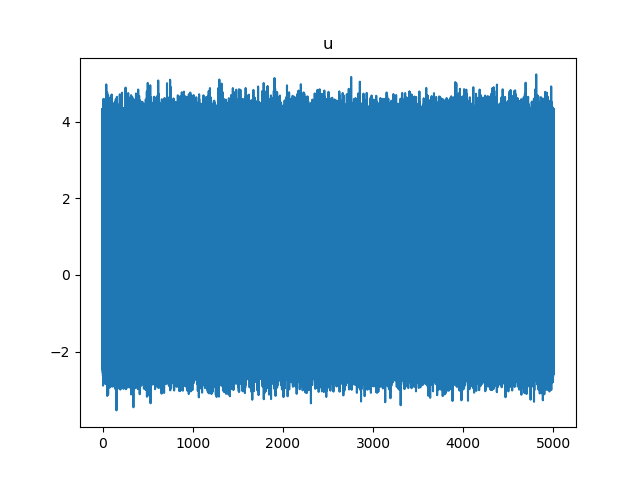

In [4]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

<IPython.core.display.Javascript object>


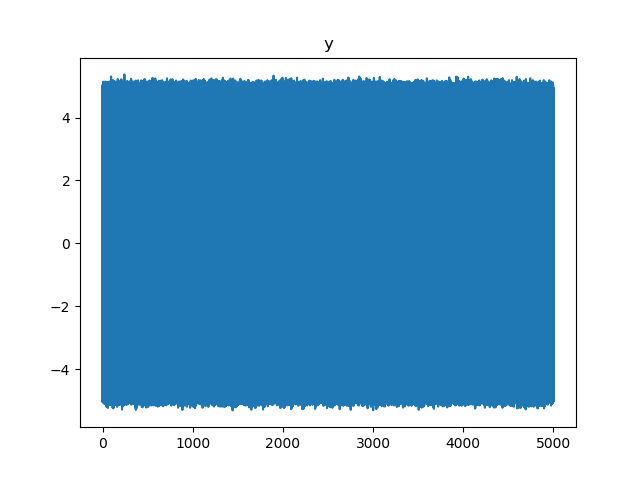

In [5]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

signals FFTs


<IPython.core.display.Javascript object>


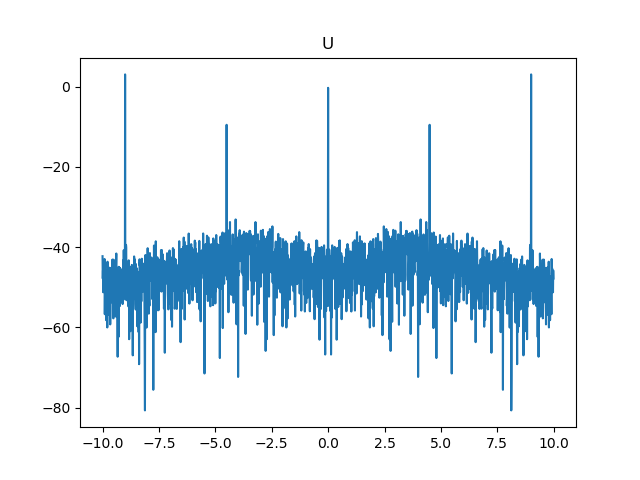

<IPython.core.display.Javascript object>


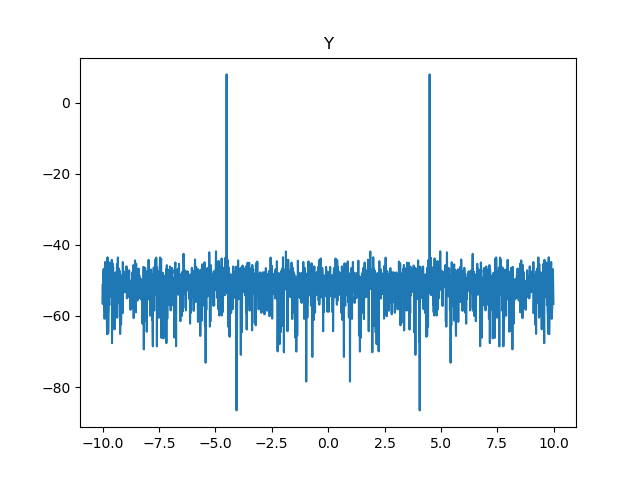

In [6]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [7]:
maxLagu = 5
maxLagy = 5
order = 2


#### $u \rightarrow y$

In [8]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=20, constantTerm=True,
                                         pho = 0.0001, elsMethod='RLS', supress=False, 
                                         mfrolsEngine='python', elsEngine='python')

Mounting matrix of features for the MFROLS method
Executing MFROLS method
term number 0
ERR 0.9030695729163662
term number 1
ERR 0.09553359372547868
term number 2
ERR 0.000191336221515982
term number 3
ERR 5.2579913578085224e-05
y(i-2) -0.4379309080835682
y(i-5) 0.282854596927142
y(i-4) 0.37535745525989783
y(i-3) -0.17505748156788015
Initiating ELS method
ELS iteration - 0
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
(99990, 9)
y(i-2) -0.43304632689287215
y(i-3) -0.1732344407782427
y(i-4) 0.3791892611000914
y(i-5) 0.28620533415446736
ELS iteration - 1
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
(99990, 9)
y(i-2) -0.029687207876485773
y(i-3) -0.4658415552185333
y(i-4) 0.8348770413248314
y(i-5) 0.11999384009210026
n(i-1) 0.030514479106434327
n(i-2) -0.18610473523108254
n(i-3) 0.3534803091511872
n(i-4) -0.575117196848781
n(i-5) -0.07751293030584323
ELS iteration - 2
Mounting matr

In [9]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=20, constantTerm=True,
                                         pho = 0.0001, supress=False, elsMethod='RLS',
                                         mfrolsEngine='fortran')

Mounting matrix of features for the MFROLS method
Executing MFROLS method
y(i-2) -0.4379309080836455
y(i-5) 0.28285459692711074
y(i-4) 0.3753574552598301
y(i-3) -0.17505748156788736
Initiating ELS method
ELS iteration - 0
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
(99990, 9)
y(i-2) -0.43304632689287215
y(i-3) -0.1732344407782427
y(i-4) 0.3791892611000914
y(i-5) 0.28620533415446736
ELS iteration - 1
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
(99990, 9)
y(i-2) -0.029687207876485773
y(i-3) -0.4658415552185333
y(i-4) 0.8348770413248314
y(i-5) 0.11999384009210026
n(i-1) 0.030514479106434327
n(i-2) -0.18610473523108254
n(i-3) 0.3534803091511872
n(i-4) -0.575117196848781
n(i-5) -0.07751293030584323
ELS iteration - 2
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
(99990, 9)
y(i-2) -0.11590871448943231
y(i-3) -0.13304158626730356


In [10]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=20, constantTerm=True,
                                         pho = 0.0001, supress=False, elsMethod='RLS', 
                                         mfrolsEngine='fortran', elsEngine='fortran')

Mounting matrix of features for the MFROLS method
Executing MFROLS method
y(i-2) -0.4379309080836455
y(i-5) 0.28285459692711074
y(i-4) 0.3753574552598301
y(i-3) -0.17505748156788736
Initiating ELS method
ELS iteration - 0
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
(99990, 9)
y(i-2) -0.43304632689360784
y(i-3) -0.1732344407778953
y(i-4) 0.3791892610992771
y(i-5) 0.2862053341547057
ELS iteration - 1
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
(99990, 9)
y(i-2) -0.02968720788881151
y(i-3) -0.4658415551994483
y(i-4) 0.8348770413077394
y(i-5) 0.11999384010732242
n(i-1) 0.030514479105696452
n(i-2) -0.1861047352200756
n(i-3) 0.35348030913277023
n(i-4) -0.575117196836148
n(i-5) -0.07751293031546895
ELS iteration - 2
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
(99990, 9)
y(i-2) -0.1159087145012187
y(i-3) -0.13304158628908536
y(i

#### $y \rightarrow u$

In [11]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=20, constantTerm=True, elsMethod='RLS', 
                                         pho=0.0001, supress=False, 
                                         mfrolsEngine='fortran', elsEngine='fortran')

Mounting matrix of features for the MFROLS method
Executing MFROLS method
y(i-1)y(i-2) 0.39980084210046296
y(i-2)y(i-3) -0.002854754723921988
y(i-5) 0.0006415270003454889
y(i-2) 0.10032311216388937
u(i-3) 0.0031422948873611445
u(i-2) -0.3026531955228288
u(i-1) 0.5070371262925301
u(i-1)u(i-5) -0.00039918469588977687
Initiating ELS method
ELS iteration - 0
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
(99990, 78)
y(i-2) 0.10032703599467602
y(i-5) 0.0006393472769736725
u(i-1) 0.5073979668666341
u(i-2) -0.3027364433499881
u(i-3) 0.003446326557875822
y(i-1)y(i-2) 0.3997443347455422
y(i-2)y(i-3) -0.003070849153721795
u(i-1)u(i-5) -0.0003996165810651734
ELS iteration - 1
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
(99990, 78)
y(i-2) 0.10084776693966738
y(i-5) 0.0021317620556758113
u(i-1) 0.5201661468663439
u(i-2) -0.30892829122297694
u(i-3) 0.006664746735812297
y(i-1)y(i-2) 0.39994303

Executing RLS method
Computing residue of the identification
(99990, 78)
y(i-2) 0.10113821172192189
y(i-5) 0.0030708170497133116
u(i-1) 0.5287975109872648
u(i-2) -0.31320846218895787
u(i-3) 0.00934270025950995
y(i-1)y(i-2) 0.399917005912784
y(i-2)y(i-3) -0.011289399180637406
u(i-1)u(i-5) -0.00045620238744249606
m(i-1) -0.10402182488251978
m(i-2) -0.04276205126681885
m(i-3) 0.03259522260061173
m(i-4) -0.03213829291630272
m(i-5) 0.02635118691614161
y(i-1)m(i-1) 0.023633975757377326
y(i-1)m(i-2) -0.03592262891793994
y(i-1)m(i-3) -0.016635078658520302
y(i-1)m(i-4) -0.020830053316667603
y(i-1)m(i-5) 0.010593673846911286
y(i-2)m(i-1) 0.04403851673448982
y(i-2)m(i-2) -0.0036976988599529822
y(i-2)m(i-3) 0.025639772954458583
y(i-2)m(i-4) -0.029995464193781525
y(i-2)m(i-5) -0.01566598011380478
y(i-3)m(i-1) 0.022896101903322585
y(i-3)m(i-2) -0.02131821312594197
y(i-3)m(i-3) -0.022475146009310252
y(i-3)m(i-4) -0.03736457162989124
y(i-3)m(i-5) 0.025416661956534293
y(i-4)m(i-1) 0.043723797580170434


Executing RLS method
Computing residue of the identification
(99990, 78)
y(i-2) 0.10113824062075745
y(i-5) 0.003070909926364137
u(i-1) 0.5287983505398625
u(i-2) -0.3132088820280264
u(i-3) 0.009342953871492431
y(i-1)y(i-2) 0.39991700541851266
y(i-2)y(i-3) -0.011289735872155354
u(i-1)u(i-5) -0.0004562019983506736
m(i-1) -0.1040224962668497
m(i-2) -0.04276153930756743
m(i-3) 0.032595791373554256
m(i-4) -0.032138441232388695
m(i-5) 0.026351150973416355
y(i-1)m(i-1) 0.02363400942179452
y(i-1)m(i-2) -0.0359225389924637
y(i-1)m(i-3) -0.01663518668160553
y(i-1)m(i-4) -0.020830150326522683
y(i-1)m(i-5) 0.010593642264620135
y(i-2)m(i-1) 0.04403861225576724
y(i-2)m(i-2) -0.0036977452977844855
y(i-2)m(i-3) 0.02563973921842136
y(i-2)m(i-4) -0.029995565105261333
y(i-2)m(i-5) -0.015666023218089246
y(i-3)m(i-1) 0.022896310967790358
y(i-3)m(i-2) -0.02131820521436491
y(i-3)m(i-3) -0.022475146297156773
y(i-3)m(i-4) -0.037364651384311436
y(i-3)m(i-5) 0.02541642775174282
y(i-4)m(i-1) 0.04372380911098208
y(

In [12]:
_, n_uy, maxLag_uy = ident.osaWithStruct(u, y, beta_uy, Duy, 2, 
                                         ustring='u', ystring='y')
n_uy

array([[ 3.60000574],
       [ 1.65567115],
       [-0.04661517],
       ...,
       [ 0.06558642],
       [-0.02893584],
       [ 0.199452  ]])

In [13]:
_, n_yu, maxLag_yu = ident.osaWithStruct(y, u, beta_yu, Dyu, 2, 
                                         ustring='y', ystring='u')
n_yu

array([[ 0.18550063],
       [ 0.3865075 ],
       [ 0.20374207],
       ...,
       [ 0.27484197],
       [ 0.03663821],
       [-0.15636504]])

### Generalised Frequency Responses

#### $u \rightarrow y$

In [14]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

0

In [15]:
Hnuy[2]

0

#### $y \rightarrow u$

In [16]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

(0.00307090997964196*exp(-0.5*I*pi*f1) + 0.101138240636889*exp(-0.2*I*pi*f1))/(1 - 0.00934295404194361*exp(-0.3*I*pi*f1) + 0.313208882273276*exp(-0.2*I*pi*f1) - 0.528798351046193*exp(-0.1*I*pi*f1))

In [17]:
Hnyu[2]

(-0.000456201997217904*(0.00307090997964196*exp(-0.5*I*pi*f1) + 0.101138240636889*exp(-0.2*I*pi*f1))*(0.00307090997964196*exp(-0.5*I*pi*f2) + 0.101138240636889*exp(-0.2*I*pi*f2))*exp(-0.5*I*pi*f1)*exp(-0.1*I*pi*f2)/((1 - 0.00934295404194361*exp(-0.3*I*pi*f1) + 0.313208882273276*exp(-0.2*I*pi*f1) - 0.528798351046193*exp(-0.1*I*pi*f1))*(1 - 0.00934295404194361*exp(-0.3*I*pi*f2) + 0.313208882273276*exp(-0.2*I*pi*f2) - 0.528798351046193*exp(-0.1*I*pi*f2))) - 0.0112897360845614*exp(-I*(0.2*pi*f1 + 0.3*pi*f2)) + 0.399917005411497*exp(-I*(0.1*pi*f1 + 0.2*pi*f2)))/(1 - 0.528798351046193*exp(-I*(0.1*pi*f1 + 0.1*pi*f2)) + 0.313208882273276*exp(-2*I*(0.1*pi*f1 + 0.1*pi*f2)) - 0.00934295404194361*exp(-3*I*(0.1*pi*f1 + 0.1*pi*f2)))

<IPython.core.display.Javascript object>


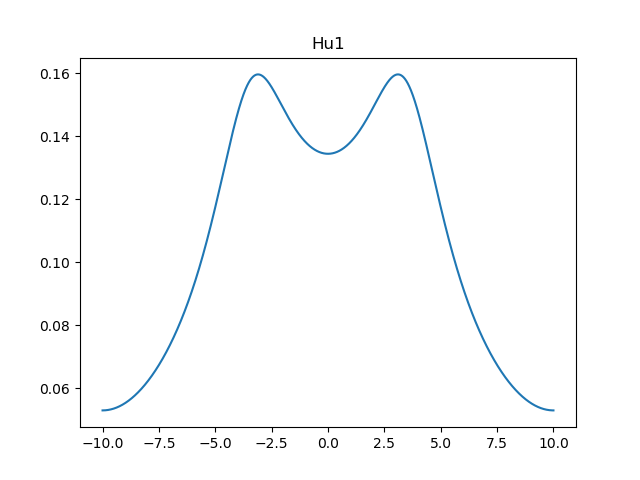

<IPython.core.display.Javascript object>


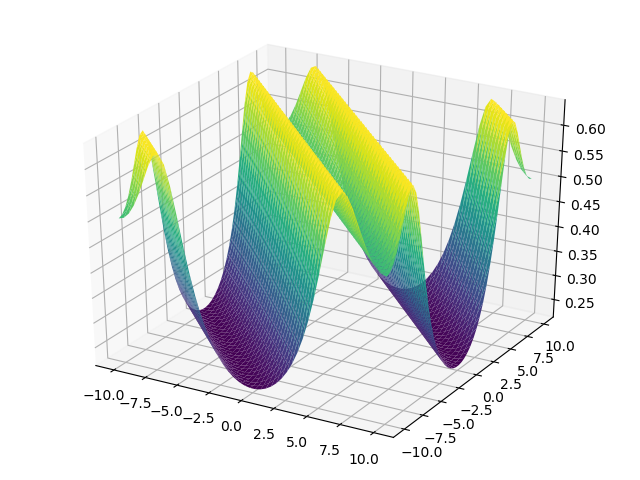

In [18]:
f1, f2 = sym.symbols('f1 f2')
Hu = sym.lambdify(f1, Hnyu[1], 'numpy')

fV = np.linspace(-Fs/2, Fs/2, 100000)


plt.figure()
plt.plot(fV, np.abs(Hu(fV)))
plt.title('Hu1')
plt.show()


plot3d(sym.Abs(Hnyu[2]), (f1,-Fs/2, Fs/2), (f2,-Fs/2, Fs/2))


### Transfer of Power between the signals

### Coherence (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [19]:
f_inputMin = 0
f_inputMax = Fs/2
maxDegree = 2
Iuy, Iyu, f, Iuyn, Iyun, IuyLinear, IyuLinear, IuynLinear, IyunLinear, IuyConf, IyuConf = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                    Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                    L=50, ustring='u', ystring='y', mfrolsEngine='python',
                                                                                                    elsEngine='fortran')

(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)


In [20]:
Iuy, Iyu, f, Iuyn, Iyun, IuyLinear, IyuLinear, IuynLinear, IyunLinear, IuyConf, IyuConf = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                    Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                    L=50, ustring='u', ystring='y', mfrolsEngine='fortran',
                                                                                                    elsEngine='fortran')

(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)
(3836, 9)


<IPython.core.display.Javascript object>


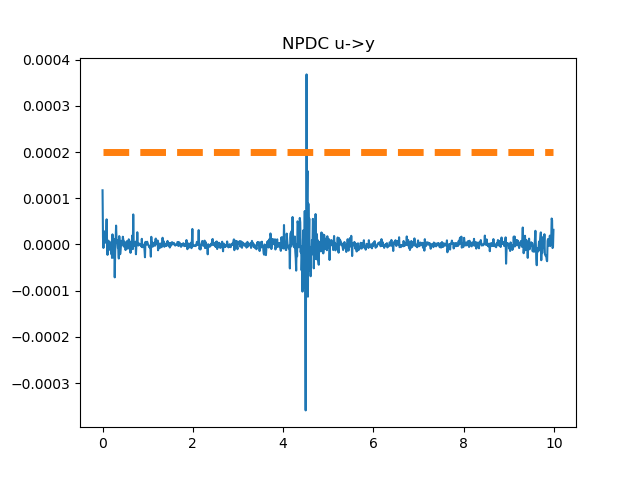

<IPython.core.display.Javascript object>


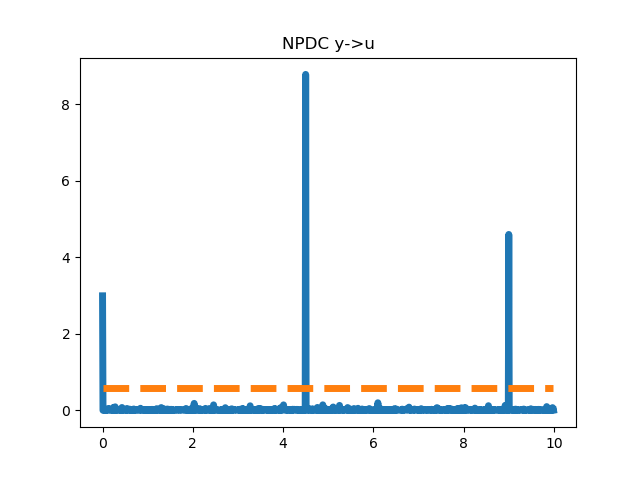

<IPython.core.display.Javascript object>


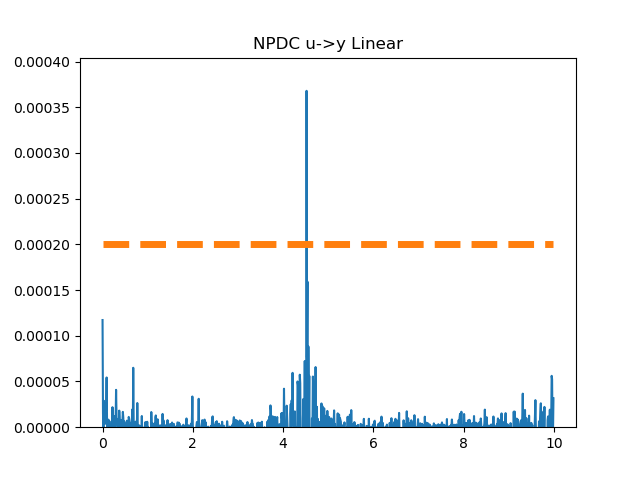

<IPython.core.display.Javascript object>


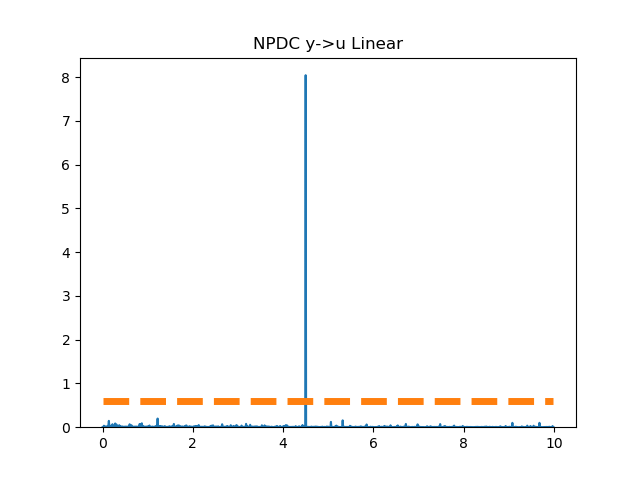

In [21]:
plt.figure()
# plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, Iuy)
plt.plot(f, np.ones_like(f)*IuyConf, '--', linewidth=5)
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
# plt.ylim(0, )
plt.title('NPDC u->y')
plt.show()

plt.figure()
# plt.plot(f, NPDCyun)
plt.plot(f, Iyu, linewidth=5)
plt.plot(f, np.ones_like(f)*IyuConf, '--', linewidth=5)
# plt.ylim(0, )
plt.title('NPDC y->u')
plt.show()
                                                                                         
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, IuyLinear)
plt.plot(f, np.ones_like(f)*IuyConf, '--', linewidth=5)
plt.ylim(0, )
plt.title('NPDC u->y Linear')
plt.show()

plt.figure()
# plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, IyuLinear)
plt.plot(f, np.ones_like(f)*IyuConf, '--', linewidth=5)
plt.ylim(0, )
plt.title('NPDC y->u Linear')
plt.show()

## Example 3

\begin{align}
    y(i) = & \sin(2\pi2i) + \sin(2\pi3i) +e_y(i-1)\\
    u(i) = & 0.5u(i-1) - 0.3u(i-2) +0.1y(i-2) + 0.1u(i-2)^2 +0.4y(i-1)y(i-2) + e_y(i-1)
\end{align}

In [ ]:
def system3(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#     y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(2, len(u)):
        y[i] = np.sin(2*np.pi*2*t[i]) + np.sin(2*np.pi*3*t[i]) + ey[i-1]
        u[i] = 0.5*u[i-1] - 0.3*u[i-2] + 0.1*y[i-2] + 0.1*u[i-2]**2 + 0.4*y[i-1]*y[i-2] + eu[i-1]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [ ]:
Fs = 20.0
N = 600

u = 0*np.random.randn(N, 1)
eu = 0.05*np.random.randn(N, 1)
ey = 0.02*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system3(u, Fs, noiseSTD=0, eu=eu, ey=ey)

In [ ]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

In [ ]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

In [ ]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [ ]:
maxLagu = 2
maxLagy = 2
order = 2


#### $u \rightarrow y$

In [ ]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=1, constantTerm=True,
                                         pho = 0.001, supress=False, elsMethod='RLS')

#### $y \rightarrow u$

In [ ]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=1, constantTerm=True,
                                         pho=0.0001, supress=False, elsMethod='RLS')

### Generalised Frequency Responses

#### $u \rightarrow y$

In [ ]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

In [ ]:
Hnuy[2]

#### $y \rightarrow u$

In [ ]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

In [ ]:
Hnyu[2]

### Transfer of Power between the signals

\begin{equation}
    I_{U\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{y_l^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|U_{u_l^-,u_n^-}\right|^2}{\left|U_{u_l^-,u_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{U\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|U_{u_l^-,u_n^-} \right|^2}{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}


where $Y_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $y$ caused by the past of the signals $u$ and $y$, $U_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $u$ caused by the past of the signals $u$ and $y$, $Y_{y_l^-,y_n^-}$ is the intrinsic part of $y$ caused by the past of the signals $y$ and the error model $e_y$ and $U_{u_l^-,u_n^-}$ is the intrinsic part of $u$ caused by the past of the signals $u$ and the error model $e_u$. 

### Coherence 1 (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [ ]:
f_inputMin = 0
f_inputMax = Fs/2
maxDegree = 2
NPDCuy, NPDCyu, f, NPDCuyn, NPDCyun, NPDCuyLinear, NPDCyuLinear, NPDCuynLinear, NPDCyunLinear = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                          Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                          L=50, ustring='u', ystring='y')
    

In [ ]:
plt.figure()
# plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, np.abs(NPDCuy))
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
plt.ylim(0, 1)
plt.title('NPDC u->y')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyun))
plt.plot(f, np.abs(NPDCyu))
plt.ylim(0, 1)
plt.title('NPDC y->u')
plt.show()



                                                                                         
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, np.abs(NPDCuyLinear))
plt.ylim(0, 1)
plt.title('NPDC u->y Linear')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, np.abs(NPDCyuLinear))
plt.ylim(0, 1)
plt.title('NPDC y->u Linear')
plt.show()

## Example 4

\begin{align}
   u(i) = & 0.5u(i-1) - 0.3u(i-2) +0.1y(i-2) + 0.1u(i-2)^2 +0.4y(i-1)y(i-2) + e_u(i-1)\\
   y(i) =& 0.3y(i-1) - y(i-2) - 0.1u(i-2) + ey(i-1)\\   
\end{align}

In [ ]:
def system4(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#    y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(2, len(u)):
        u[i] = 0.5*u[i-1] - 0.3*u[i-2] + 0.1*y[i-2] + 0.1*u[i-2]**2 + 0.4*y[i-1]*y[i-2] + eu[i-1]
        y[i] = 0.3*y[i-1] - y[i-2] - 0.1*u[i-2] + ey[i-1]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [ ]:
Fs = 20.0
N = 100000

u = 0*np.random.randn(N, 1)
eu = 0.1*np.random.randn(N, 1)
ey = 0.1*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system4(u, Fs, noiseSTD=0, eu=eu, ey=ey)

In [ ]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

In [ ]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

In [ ]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [ ]:
maxLagu = 2
maxLagy = 2
order = 2


#### $u \rightarrow y$

In [ ]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=20, constantTerm=True,
                                         pho = 0.005, supress=False)

#### $y \rightarrow u$

In [ ]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=20, constantTerm=True,
                                         pho=0.0001, supress=False)

### Generalised Frequency Responses

#### $u \rightarrow y$

In [ ]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

In [ ]:
Hnuy[2]

#### $y \rightarrow u$

In [ ]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

In [ ]:
Hnyu[2]

### Transfer of Power between the signals

\begin{equation}
    I_{U\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{y_l^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|U_{u_l^-,u_n^-}\right|^2}{\left|U_{u_l^-,u_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{U\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|U_{u_l^-,u_n^-} \right|^2}{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}


where $Y_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $y$ caused by the past of the signals $u$ and $y$, $U_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $u$ caused by the past of the signals $u$ and $y$, $Y_{y_l^-,y_n^-}$ is the intrinsic part of $y$ caused by the past of the signals $y$ and the error model $e_y$ and $U_{u_l^-,u_n^-}$ is the intrinsic part of $u$ caused by the past of the signals $u$ and the error model $e_u$. 

### Coherence (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [ ]:
L = 50
NPDCuy, NPDCyu, f, NPDCuyn, NPDCyun, NPDCuyLinear, NPDCyuLinear, NPDCuynLinear, NPDCyunLinear = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                          Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                          N=L, ustring='u', ystring='y')
    


Th = 1 - (1-0.95)**(1/(L-1))

In [ ]:
plt.figure()
# plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, np.abs(NPDCuy))
plt.plot(f, Th*np.ones_like(f), '--k')
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
plt.ylim(0, 1)
plt.title('NPDC u->y')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyun))
plt.plot(f, np.abs(NPDCyu))
plt.plot(f, Th*np.ones_like(f), '--k')
plt.ylim(0, 1)
plt.title('NPDC y->u')
plt.show()



                                                                                         
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, np.abs(NPDCuyLinear))
plt.plot(f, Th*np.ones_like(f), '--k')
plt.ylim(0, 1)
plt.title('NPDC u->y Linear')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, np.abs(NPDCyuLinear))
plt.plot(f, Th*np.ones_like(f), '--k')
plt.ylim(0, 1)
plt.title('NPDC y->u Linear')
plt.show()

## Example 5

\begin{align}
   u(i) = &  e_u(i-1)\\
   y(i) =& e_y(i-1)\\   
\end{align}

In [ ]:
def system5(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#    y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(0, len(u)):
        u[i] = eu[i]
        y[i] = ey[i]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [ ]:
Fs = 20.0
N = 100000

u = 0*np.random.randn(N, 1)
eu = 0.1*np.random.randn(N, 1)
ey = 0.1*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system5(u, Fs, noiseSTD=0, eu=eu, ey=ey)

In [ ]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

In [ ]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

In [ ]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [ ]:
maxLagu = 2
maxLagy = 2
order = 2


#### $u \rightarrow y$

In [ ]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=200, constantTerm=True,
                                         pho = 0.0001, supress=False)

#### $y \rightarrow u$

In [ ]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=200, constantTerm=True,
                                         pho=0.0001, supress=False)

### Generalised Frequency Responses

#### $u \rightarrow y$

In [ ]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

In [ ]:
Hnuy[2]

#### $y \rightarrow u$

In [ ]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

In [ ]:
Hnyu[2]

### Transfer of Power between the signals

\begin{equation}
    I_{U\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{y_l^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|U_{u_l^-,u_n^-}\right|^2}{\left|U_{u_l^-,u_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{U\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|U_{u_l^-,u_n^-} \right|^2}{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}


where $Y_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $y$ caused by the past of the signals $u$ and $y$, $U_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $u$ caused by the past of the signals $u$ and $y$, $Y_{y_l^-,y_n^-}$ is the intrinsic part of $y$ caused by the past of the signals $y$ and the error model $e_y$ and $U_{u_l^-,u_n^-}$ is the intrinsic part of $u$ caused by the past of the signals $u$ and the error model $e_u$. 

### Coherence 1 (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [ ]:
NPDCuy, NPDCyu, f, NPDCuyn, NPDCyun, NPDCuyLinear, NPDCyuLinear, NPDCuynLinear, NPDCyunLinear = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                          Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                          N=50, ustring='u', ystring='y')
    

In [ ]:
plt.figure()
plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, np.abs(NPDCuy))
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
plt.ylim(0, 1)
plt.title('NPDC u->y')
plt.show()

plt.figure()
plt.plot(f, np.abs(NPDCyun))
plt.plot(f, np.abs(NPDCyu))
plt.ylim(0, 1)
plt.title('NPDC y->u')
plt.show()
                                                                                       
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, np.abs(NPDCuyLinear))
plt.ylim(0, 1)
plt.title('NPDC u->y Linear')
plt.show()

plt.figure()
plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, np.abs(NPDCyuLinear))
plt.ylim(0, 1)
plt.title('NPDC y->u Linear')
plt.show()

In [ ]:
L = 1
Th = (np.log((np.abs(np.mean(Y)/L)**2)/(np.abs(1e-7)**2))/
      np.sqrt(2*np.log((np.abs(np.mean(Y)/L)**2)/(np.abs(1e-7)**2))**2 +
              + 2*np.log((np.abs(np.mean(Y)/L)**2)/(np.abs(np.mean(Y)/L+1e-7)**2))**2))

Th

In [ ]:
1/np.sqrt(2)